In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import utils

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.datasets import load_digits
from sklearn.manifold import TSNE
import matplotlib.patheffects as PathEffects

Feature Selection = reduce the number of features on the dataset by selection the most relevant ones
Feature Extraction = reduce the number of features by projecting the data into a lower dimensional feature space

# Principal Component Analysis (PCA)

$$\vec{x} W = \vec{z}$$

$\vec{x} \in \mathbb{R}^{d}$ = original feature vector with $d$ dimensions
$W \in \mathbb{R}^{d \times k}$ = PCA transformation matrix (eigenvectors)
$\vec{z} \in \mathbb{R}^{k}$ = transformed feature vector with $k$ dimensions

## PCA Step-by-Step 


Eigenvalues 
 [4.84274532 2.41602459 1.54845825 0.96120438 0.84166161 0.6620634
 0.51828472 0.34650377 0.3131368  0.10754642 0.21357215 0.15362835
 0.1808613 ]


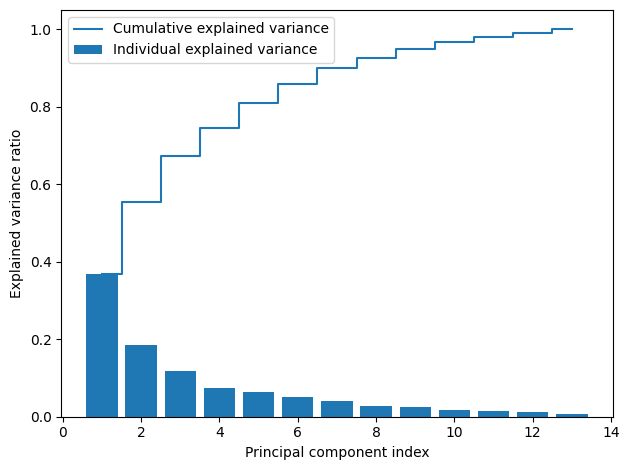

In [37]:
# PCA step by step

# Load dataset
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium',
                   'Total phenols', 'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline']

# Split dataset into training and test sets
# First column is the class label, the rest are features
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

# Standardize the features
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

# Covariance matrix used to compute eigenvectors and eigenvalues
# Symmetric matrices (like covariance) do not result in eigenvalues with complex components
cov_mat = np.cov(X_train_std.T)

# Compute eigenvalues and eigenvectors
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
print('\nEigenvalues \n', eigen_vals)

# Plotted variance explained ratios
# The graph shows that 40% of the variance is explained by the first principal component
# and 60% by the first two principal components
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
plt.bar(range(1,14), var_exp, align='center', label='Individual explained variance')
plt.step(range(1,14), cum_var_exp, where='mid', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [38]:
# Sort eigenvalues in decreasing order
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

# Select k eigenvectors that correspond to the k largest eigenvalues, in this case k=2
w = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))
print('Matrix W (d x k):\n', w)

# Projecting a single example onto the PCA subspace
print('Project example:\n', X_train_std[0].dot(w))

Matrix W (d x k):
 [[-0.13724218  0.50303478]
 [ 0.24724326  0.16487119]
 [-0.02545159  0.24456476]
 [ 0.20694508 -0.11352904]
 [-0.15436582  0.28974518]
 [-0.39376952  0.05080104]
 [-0.41735106 -0.02287338]
 [ 0.30572896  0.09048885]
 [-0.30668347  0.00835233]
 [ 0.07554066  0.54977581]
 [-0.32613263 -0.20716433]
 [-0.36861022 -0.24902536]
 [-0.29669651  0.38022942]]
Project example:
 [2.38299011 0.45458499]


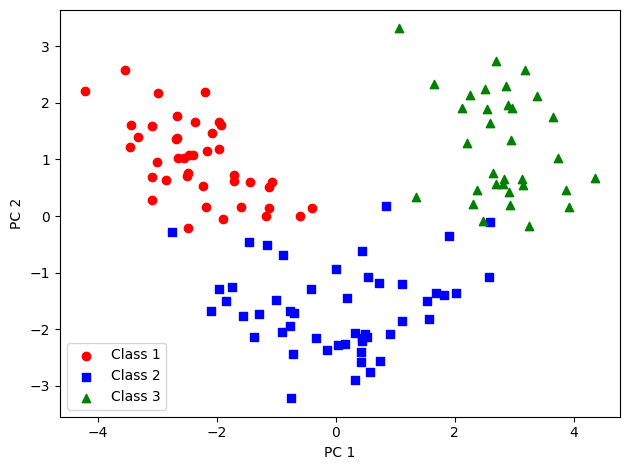

In [39]:
# Transform the entire training dataset
X_train_pca = X_train_std.dot(w)

# Plot transformed dataset
colors = ['r', 'b', 'g']
markers = ['o', 's', '^']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train==l, 0],
                X_train_pca[y_train==l, 1],
                c=c, label=f'Class {l}', marker=m)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

# PCA in Scikit-Learn

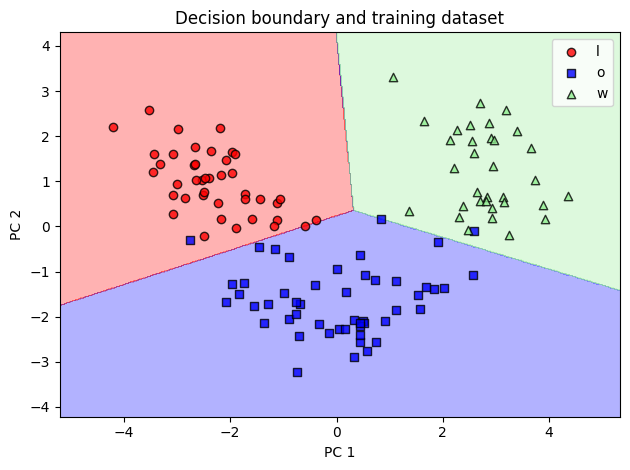

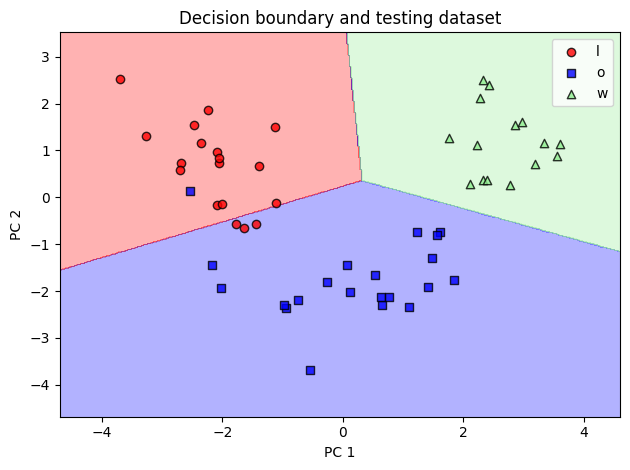

In [40]:
# "Model"
pca = PCA(n_components=2)
lr = LogisticRegression(multi_class='ovr', random_state=1, solver='lbfgs')

# Dimensionality Reduction
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

# Fitting the model
lr.fit(X_train_pca, y_train)

# Decision boundary and training dataset
utils.plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend("lower left")
plt.title("Decision boundary and training dataset")
plt.tight_layout()
plt.show()

# Decision boundary and testing dataset
utils.plot_decision_regions(X_test_pca, y_test, classifier=lr)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend("lower left")
plt.title("Decision boundary and testing dataset")
plt.tight_layout()
plt.show()

### PCA assessing features contribution

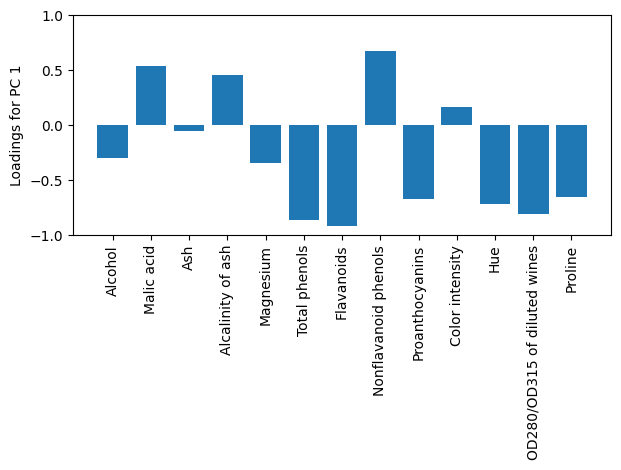

In [45]:
# For each PCA dimension the following equation allows us to see how much each feature contributes
# to the total variance of that PCA dimension (eigenvalues). This feature variance contribution is
# usually referred to as loading.
# Calculate for our manual PCA using numpy.
loadings = eigen_vecs * np.sqrt(eigen_vals)

# Plot the loadings for the first principal component, in this case loadings[:, 0]
# We can see that alcohol is negatively correlated with this feature, while malic
# acid is positive correlated.
fig, ax = plt.subplots()
ax.bar(range(13), loadings[:, 0], align='center')
ax.set_ylabel('Loadings for PC 1')
ax.set_xticks(range(13))
ax.set_xticklabels(df_wine.columns[1:], rotation=90)
plt.ylim([-1, 1])
plt.tight_layout()
plt.show()

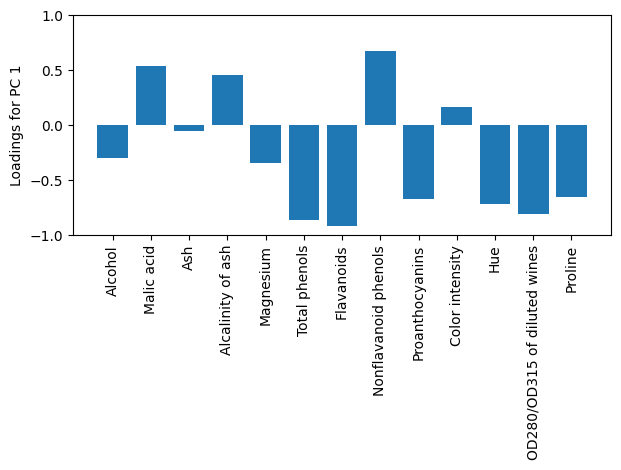

In [48]:
# Calculating loadings for PCA obtained via scikit-learn
sklearn_loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Similarly plot the loadings for the PC 1
fix, ax = plt.subplots()
ax.bar(range(13), sklearn_loadings[:, 0], align='center')
ax.set_ylabel('Loadings for PC 1')
ax.set_xticks(range(13))
ax.set_xticklabels(df_wine.columns[1:], rotation=90)
plt.ylim([-1, 1])
plt.tight_layout()
plt.show()

# Linear Discriminant Analysis

In [51]:
# Steps
# Standardize the features
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [52]:
# Calculate the mean vectors for each class
np.set_printoptions(precision=4)
mean_vecs = []
for label in range(1,4):
    # Mean each column (feature) for each class
    mean_vecs.append(np.mean(X_train_std[y_train==label], axis=0))
    print(f'Mean Vector (MV) {label}: {mean_vecs[label-1]}\n')

Mean Vector (MV) 1: [ 0.9066 -0.3497  0.3201 -0.7189  0.5056  0.8807  0.9589 -0.5516  0.5416
  0.2338  0.5897  0.6563  1.2075]

Mean Vector (MV) 2: [-0.8749 -0.2848 -0.3735  0.3157 -0.3848 -0.0433  0.0635 -0.0946  0.0703
 -0.8286  0.3144  0.3608 -0.7253]

Mean Vector (MV) 3: [ 0.1992  0.866   0.1682  0.4148 -0.0451 -1.0286 -1.2876  0.8287 -0.7795
  0.9649 -1.209  -1.3622 -0.4013]


In [56]:
# Calculate the within-class scatter matrix S_W
d = 13 # number of features
S_W = np.zeros((d,d))
for label, mv in zip(range(1,4), mean_vecs):
    class_scatter = np.zeros((d,d))
    for row in X_train_std[y_train == label]:
        row, mv = row.reshape(d, 1), mv.reshape(d, 1)
        class_scatter += (row - mv).dot((row - mv).T)
    S_W += class_scatter
print(f'Within-class scatter matrix: {S_W.shape[0]}x{S_W.shape[1]}')

# The class labels in the training dataset are not uniformly distributed, which violates one
# of the assumptions made from LDA
print('Class label distribution:', np.bincount(y_train)[1:])

# To overcome the uniformly distributed problem we scale each individual class_scatter based
# on the number of classes. This computation is the same as calculating the covariance matrix.
S_W = np.zeros((d,d))
for label, mv in zip(range(1,4), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train==label].T)
    S_W += class_scatter
print(f'Scaled within-class scatter matrix: {S_W.shape[0]}x{S_W.shape[1]}')

Within-class scatter matrix: 13x13
Class label distribution: [41 50 33]
Scaled within-class scatter matrix: 13x13


In [59]:
# Now we calculate the between-class scatter matrix S_B
# This is calculated across all classes, differently of the within-class one
mean_overall = np.mean(X_train_std, axis=0)
mean_overall = mean_overall.reshape((d, 1))

d = 13 # number of features
S_B = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vecs):
    n = X_train_std[y_train == i+1, :].shape[0]
    mean_vec = mean_vec.reshape(d,1) # Make column vector
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)

print(f'Between-class scatter matrix: {S_B.shape[0]}x{S_B.shape[1]}')

Between-class scatter matrix: 13x13


In [65]:
# Selecting linear discriminants for the new feature subspace
# These steps are similar to PCA, however instead of running PCA on the covariance matrix
# we run it on the S_W^-1*S_B
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

# Compute eigen pars, sort by descending eigen values
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:,i]) for i in range(len(eigen_vals))]
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)
print('Eigenvalues in descending order:\n')
for pair in eigen_pairs:
    print(pair[0]) # Position 0 is eigenvalue

# In LDA the number of discriminants is at most c-1 (c is the number of classes), which in
# this example is 3. Notice only c-1 (2 classes) are non-zero in the output.

Eigenvalues in descending order:

349.617808905994
172.76152218979382
2.5481445655158925e-14
2.5481445655158925e-14
2.338176411255993e-14
2.338176411255993e-14
1.4368252223521912e-14
1.4368252223521912e-14
6.3737818001526064e-15
4.514488639250919e-15
4.514488639250919e-15
2.5784328775550555e-16
0.0


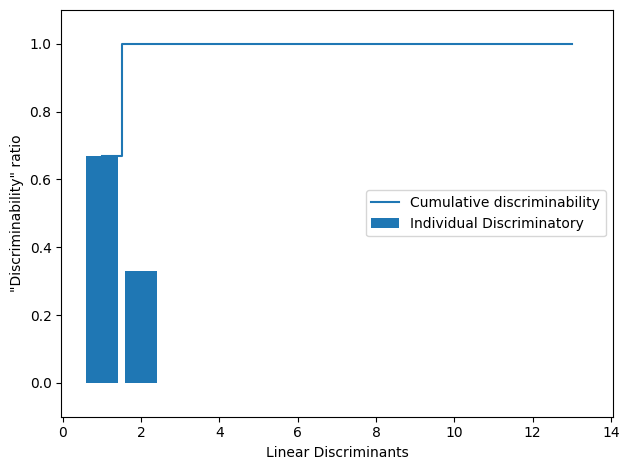

In [69]:
# Let's plot how much information is captured by the LDA
total = sum(eigen_vals.real)
discr = [(i / total) for i in sorted(eigen_vals.real, reverse=True)] # class discriminatory information
cum_discr = np.cumsum(discr)

# In this plot is possible to see how the two linear discriminants capture all information
plt.bar(range(1, 14), discr, align='center', label='Individual Discriminatory')
plt.step(range(1, 14), cum_discr, where='mid', label='Cumulative discriminability')
plt.ylabel('"Discriminability" ratio')
plt.xlabel('Linear Discriminants')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [70]:
# Let's now create the transformation matrix with the discriminant eigenvectors
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real,
               eigen_pairs[1][1][:, np.newaxis].real))
print('Matrix W:\n', w)

Matrix W:
 [[-0.1481 -0.4092]
 [ 0.0908 -0.1577]
 [-0.0168 -0.3537]
 [ 0.1484  0.3223]
 [-0.0163 -0.0817]
 [ 0.1913  0.0842]
 [-0.7338  0.2823]
 [-0.075  -0.0102]
 [ 0.0018  0.0907]
 [ 0.294  -0.2152]
 [-0.0328  0.2747]
 [-0.3547 -0.0124]
 [-0.3915 -0.5958]]


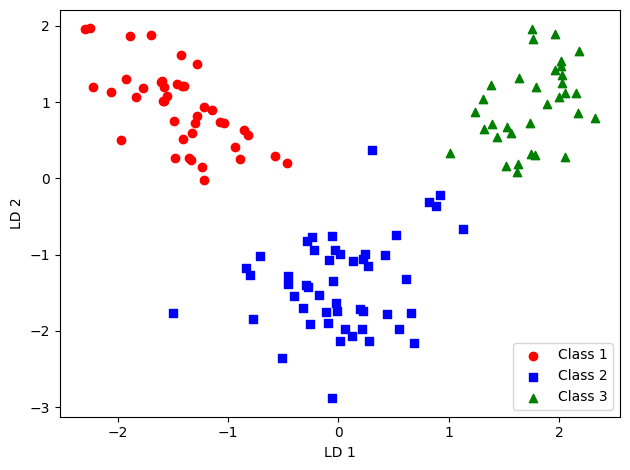

In [71]:
# Projecting examples onto the new subspace
X_train_lda = X_train_std.dot(w)

# Printing the classes discriminated in the new subspace
colors = ['r', 'b', 'g']
markers = ['o', 's', '^']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train==l, 0],
                X_train_lda[y_train==l, 1] * (-1),
                c=c, label=f'Class {l}', marker=m)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

### Let's now re-calculate LDA but this time using Scikit-learn

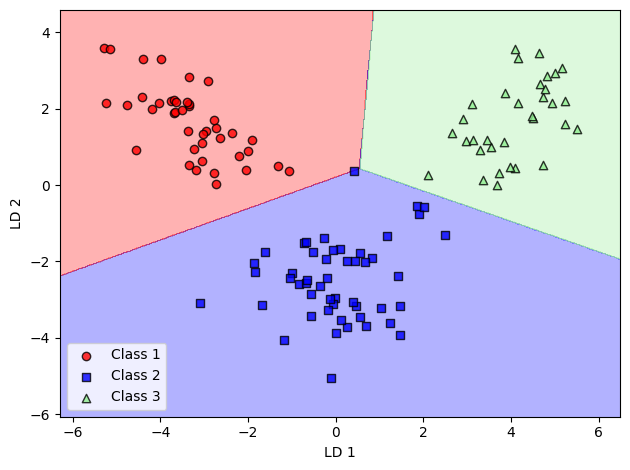

In [73]:
# Feature extracting with Scikit-learn Linear Discriminant Analysis
lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)

# Logistic regression on the new subspace
lr = LogisticRegression(multi_class='ovr', random_state=1, solver='lbfgs')
lr = lr.fit(X_train_lda, y_train)

# Plot decision boundary
# Notice that on training data only one example was misclassified with Logistic Regression
utils.plot_decision_regions(X_train_lda, y_train, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

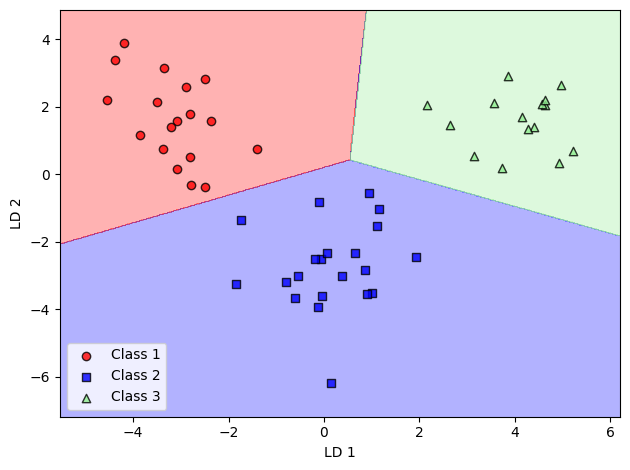

In [74]:
# Let's see the results on the test dataset now
X_test_lda = lda.transform(X_test_std)

# Plot decision boundary
# In this example it got all samples right
utils.plot_decision_regions(X_test_lda, y_test, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

# Nonlinear Dimensionality Reduction and Visualization 

Technique: t-distributed stochastic neighbor embedding (t-SNE), frequently used to visualize high dimensional
datasets in two or three dimensions. Also, this type of technique is important for problems where the data is
non-separable through a linear combination. The problem with these techniques is that it's hard to validate if
the parameters are good or not, that's because there's no way to visualize (plot) high-dimensional data. 

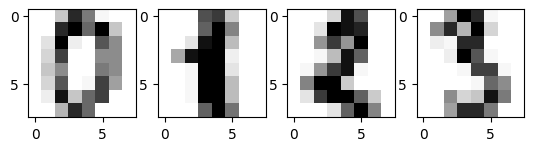

In [77]:
# Differently from PCA and LDA, t-SNE is intended only for visualization because it requires
# all dataset and cannot be applied later on to test points. The code below applies t-SNE to
# visualize the handwritten dataset
digits = load_digits()

fig, ax = plt.subplots(1, 4)
for i in range(4):
    ax[i].imshow(digits.images[i], cmap='Greys')
plt.show()

In [78]:
# A tabular representation of the 1797 samples of 8x8 digits
digits.data.shape

(1797, 64)

In [80]:
y_digits = digits.target
X_digits = digits.data

# There are additional hyperparameters, perplexity and learning rate (assumed the defaults)  
tsne = TSNE(n_components=2, init='pca', random_state=123)
X_digits_tsne = tsne.fit_transform(X_digits)

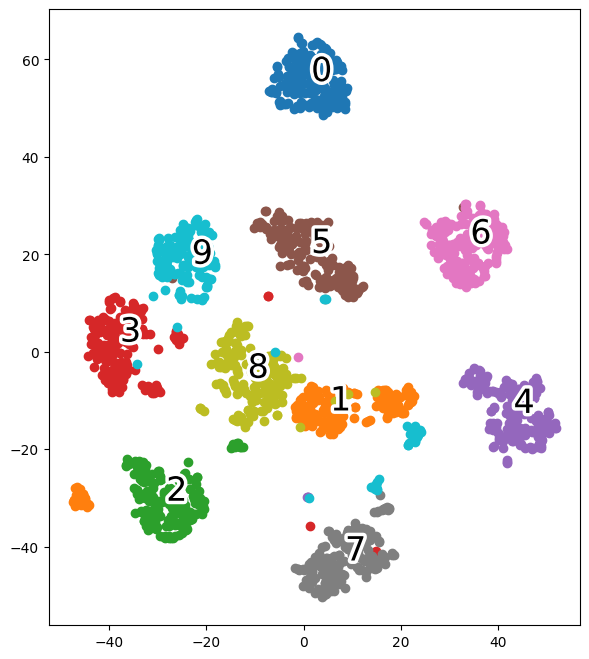

In [82]:
# Visualizing the result
def plot_projection(x, colors):
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')

    for i in range(10): # Ten digits
        plt.scatter(x[colors == i, 0],
                    x[colors == i, 1])

    for i in range(10): # Ten digits
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        # Prints the text positioned at the median of the datapoints.
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])

plot_projection(X_digits_tsne, y_digits)
plt.show()

Uniform Manifold Approximation and Projection (UMAP) is another nonlinear dimensionality reduction technique, which is
more interesting than t-SNE because it allows apply transformation on non-trained data, like in PCA and LDA.